This demonstrates how to create and train a sequence-to-sequence Transformer model to translate Portuguese into English.

That's a lot to digest, the goal of this tutorial is to break it down into easy to understand parts. In this tutorial you will:

1. Prepare the data.
2. Implement necessary components:
  - Positional embeddings.
  - Attention layers.
  - The encoder and decoder.
3. Build & train the Transformer.
4. Generate translations.
5. Export the model

# Setup

In [69]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found


# Import the necessary modules

In [70]:
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text

# Download the dataset
Use TensorFlow Datasets to load the Portuguese-English translation datasetD Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [71]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info= True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [72]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese: ')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()
  print('> examples in English: ')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese: 
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> examples in English: 
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


# Setup th tokenizer
Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters

In [73]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [74]:
tokenizers = tf.saved_model.load(model_name)

In [75]:
# the tf.saved_model contains two text tokenizers, one for english and on efor portuguese

In [76]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The tokenize method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [77]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [78]:
encoded = tokenizers.en.tokenize(en_examples)
print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [79]:
# The detokenize method attempts to convert these token IDs back to human-readable text:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [80]:
# The lower level lookup method converts from token-IDs to token text:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

In [81]:
# the distribution of tokens per example in the dataset is as follows
lengths = []
for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

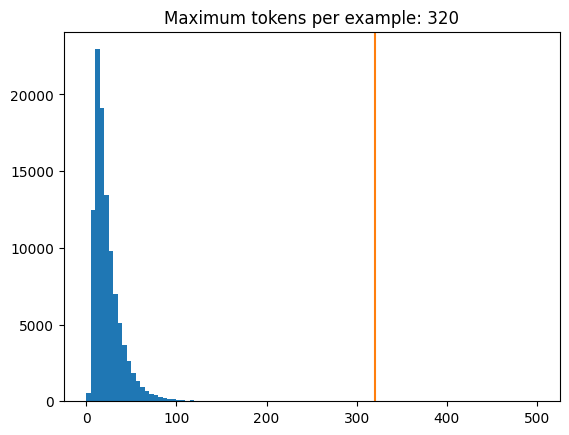

In [82]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

The following function takes batches of text as input, and converts them to a format suitable for training.

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.

In [83]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

In [84]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [85]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

# Test the dataset

In [86]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [87]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 81)
(64, 74)
(64, 74)


In [88]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   78  232  833  201   71 3455  258 2366 5936], shape=(10,), dtype=int64)
tf.Tensor([  78  232  833  201   71 3455  258 2366 5936   88], shape=(10,), dtype=int64)


In [89]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


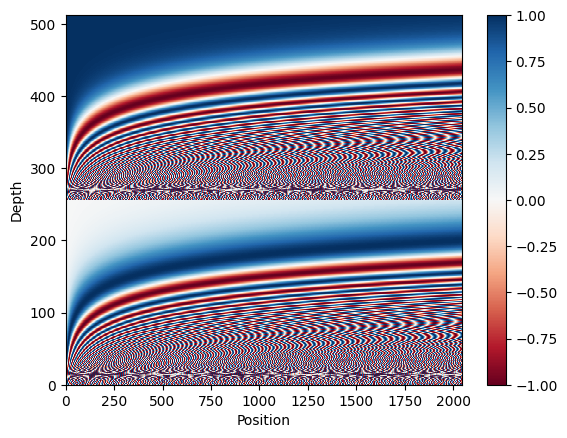

In [90]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

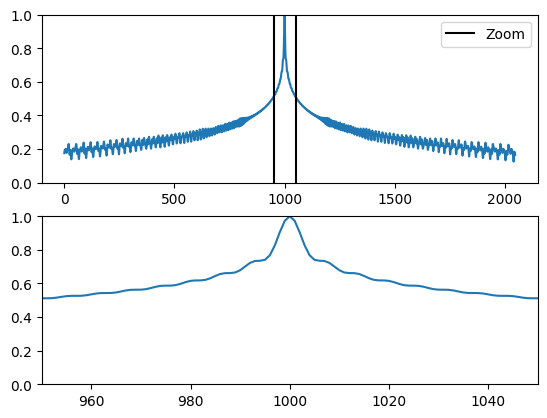

In [91]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [92]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [93]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [94]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 74), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [95]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [96]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [97]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 81, 512)
(64, 74, 512)
(64, 74, 512)


In [98]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [99]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 81, 512)
(64, 81, 512)


In [100]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [101]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 74, 512)
(64, 74, 512)


In [102]:
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

In [103]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [104]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 74, 512)
(64, 74, 512)


In [105]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [106]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 81, 512)
(64, 81, 512)


In [107]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [108]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 81)
(64, 81, 512)


In [109]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [110]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 74, 512)
(64, 81, 512)
(64, 74, 512)


In [111]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [112]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 74)
(64, 81, 512)
(64, 74, 512)


In [113]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 74, 81])

# Transformer
Now we have encoder and decoder.

In [114]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

# Hyperparameters

In [115]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [116]:
# initiate the transformer
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [117]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 74)
(64, 81)
(64, 74, 7010)


In [118]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 74, 81)


In [119]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  3632768   
                                                                 
 decoder_4 (Decoder)         multiple                  5647104   
                                                                 
 dense_85 (Dense)            multiple                  904290    
                                                                 
Total params: 10184162 (38.85 MB)
Trainable params: 10184162 (38.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [120]:
# Setup the optimizers
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [121]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

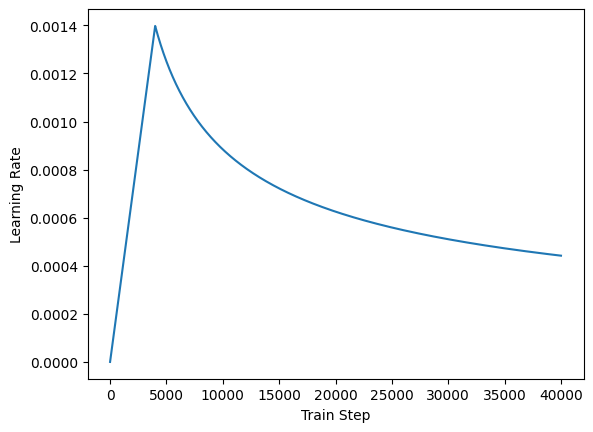

In [122]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

# Setup the loss and metrics

In [123]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

# Train the model

In [124]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [125]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20
810/810 [==============================] - 302s 307ms/step - loss: 6.5927 - masked_accuracy: 0.1387 - val_loss: 5.0362 - val_masked_accuracy: 0.2472
Epoch 2/20
810/810 [==============================] - 204s 251ms/step - loss: 4.5716 - masked_accuracy: 0.2986 - val_loss: 4.0289 - val_masked_accuracy: 0.3606
Epoch 3/20
810/810 [==============================] - 200s 246ms/step - loss: 3.8143 - masked_accuracy: 0.3809 - val_loss: 3.4766 - val_masked_accuracy: 0.4325
Epoch 4/20
810/810 [==============================] - 200s 246ms/step - loss: 3.2770 - masked_accuracy: 0.4397 - val_loss: 3.0448 - val_masked_accuracy: 0.4795
Epoch 5/20
810/810 [==============================] - 197s 243ms/step - loss: 2.8902 - masked_accuracy: 0.4827 - val_loss: 2.7349 - val_masked_accuracy: 0.5159
Epoch 6/20
810/810 [==============================] - 197s 242ms/step - loss: 2.5775 - masked_accuracy: 0.5206 - val_loss: 2.5184 - val_masked_accuracy: 0.5460
Epoch 7/20
810/810 [====================

In [126]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [127]:
translator = Translator(tokenizers, transformer)

In [128]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

# Example 1

In [129]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to fix .
Ground truth   : this is a problem we have to solve .


# Example 2

In [130]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard this idea .
Ground truth   : and my neighboring homes heard about this idea .


# Example 3

In [131]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to share a lot of quickly share with you some stories of some magic things that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


In [132]:
# create the attentation plots
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


In [133]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [134]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [135]:
# these are the input (portuguese) tokens
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

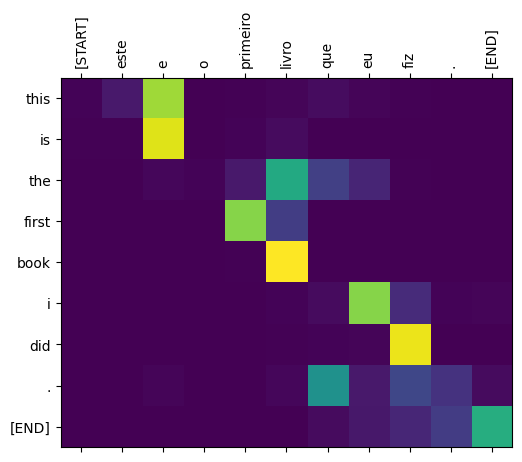

In [136]:
# these are the output (english) tokens
translated_tokens
plot_attention_head(in_tokens, translated_tokens, attention)
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

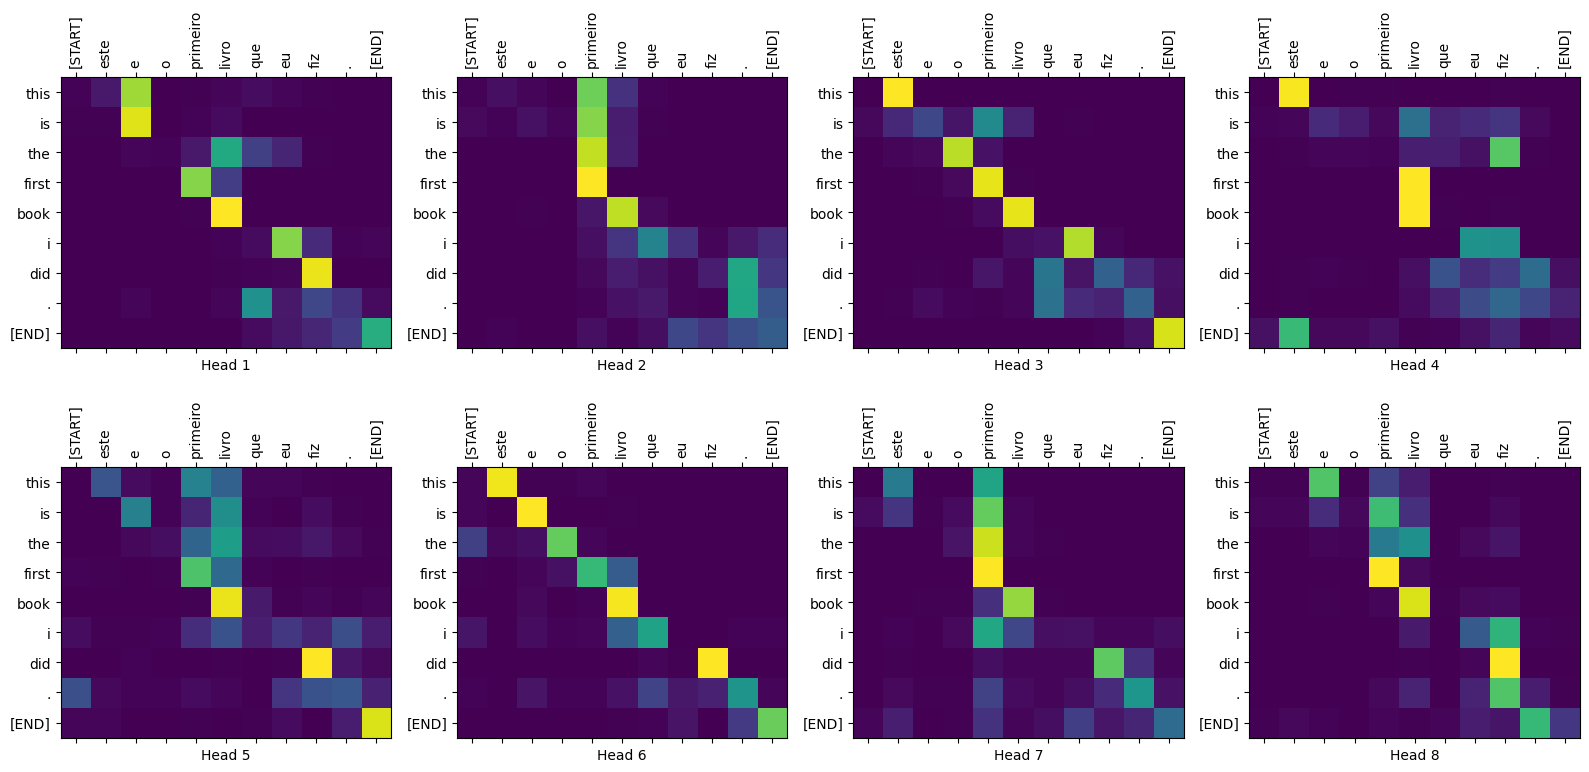

In [137]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triops in enclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


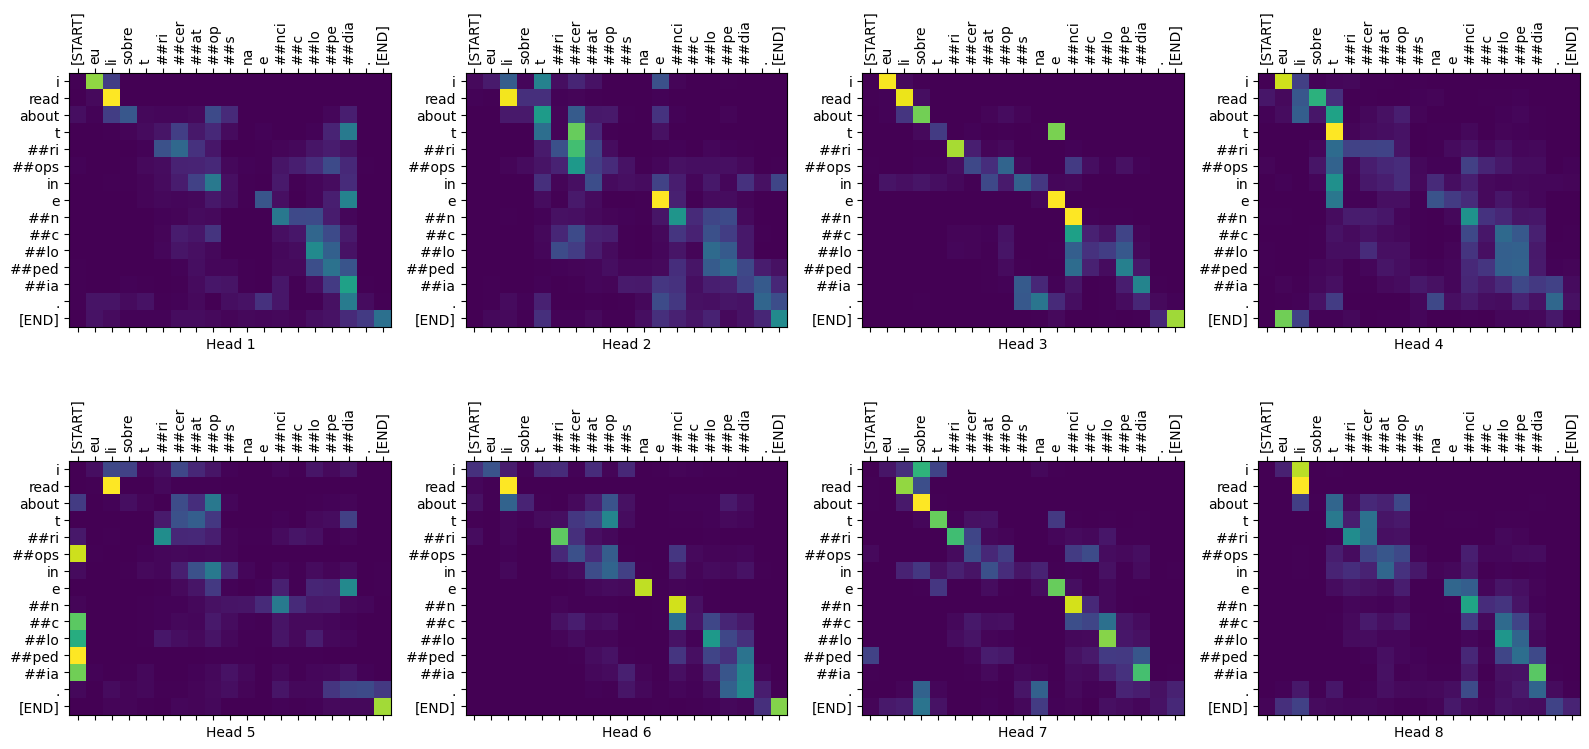

In [138]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

# Export the model


In [139]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result


In [140]:
translator = ExportTranslator(translator)


In [141]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [142]:
tf.saved_model.save(translator, export_dir='translator')

In [143]:
reloaded = tf.saved_model.load('translator')

In [144]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'